# Eksploratorna analiza podataka

Na početku ćemo modificirati naše podatke kako bismo mogli poboljšati učenje. Glavni ciljevi su:
* Uklanjanje nebitnih atributa 
    * atributi koji su međusobno visoko korelirani
    * atributi koji ne utječu na cijenu, a ne pojavljuju se previše u podacima
* Uklanjanje outliera
    * Pri učenju, ako postoje, outlieri mogu pogoršat predikciju
* Dodavanje novih atributa koji nisu u datasetu na temelju dostupnih atributa


In [46]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

## Uklanjanje koreliranih podataka

In [47]:
numeric_columns=df.select_dtypes(include=['int64', 'float64']).columns
df_numeric_corr = df[numeric_columns].corr().drop('SalePrice',axis=1).drop('SalePrice',axis=0).drop('Id', axis=0).drop('Id', axis=1)

In [48]:
correlated={row:column for column in df_numeric_corr.columns
    for row in df_numeric_corr.columns if df_numeric_corr[row][column] > 0.7 and row!=column
        }

In [49]:
correlated

{'GarageYrBlt': 'YearBuilt',
 '1stFlrSF': 'TotalBsmtSF',
 'TotalBsmtSF': '1stFlrSF',
 'TotRmsAbvGrd': 'GrLivArea',
 'GrLivArea': 'TotRmsAbvGrd',
 'YearBuilt': 'GarageYrBlt',
 'GarageArea': 'GarageCars',
 'GarageCars': 'GarageArea'}

Vidimo da su `GarageYrBlt` i `YearBuilt` visoko korelirani jer su se garaže većinom gradile isto kada i kuća, pa je taj atribut doista nepotreban. Nadalje `GarageArea` i `GarageCars` su visoko korelirani i pretpostavljamo da je više kvadratura garaže bitna, nego što je činjenica koliko autiju stane u garažu pa mičemo atribut `GarageCars`. Ostale atribute ostavljamo jer su oni možda bitni pri predikciji, npr. vidimo da su kvadratura podruma i kvadratura 1. kata jako povezani, ali možda veličina podruma utječe na cijenu cijele kuće. Slično za ostale atribute.

In [50]:
df.drop('GarageYrBlt', axis=1, inplace=True)
df.drop('GarageCars', axis=1, inplace=True)

## Uklanjanje outliera

In [51]:
import matplotlib.pyplot as plt
%matplotlib agg

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(15,9))

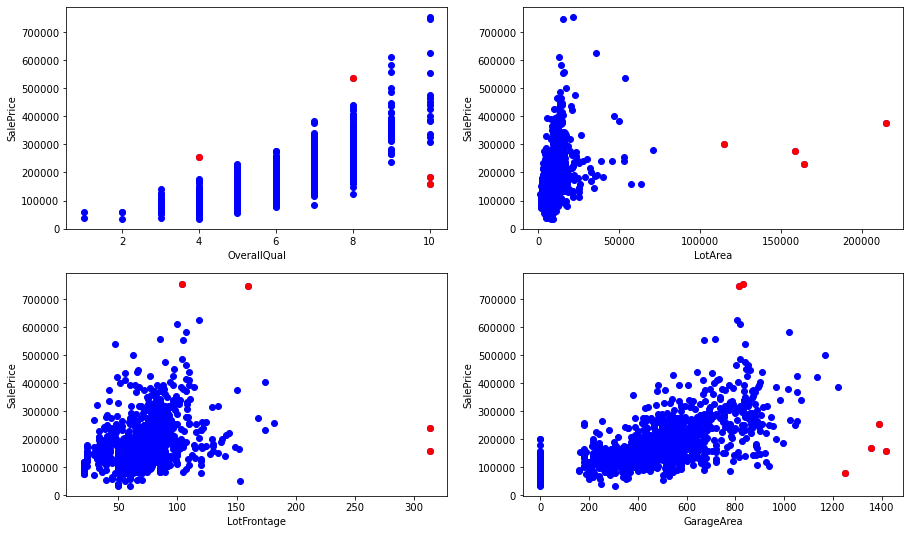

In [52]:
ax1.scatter(df['OverallQual'],df['SalePrice'], color='blue' )
ax1.scatter(df[(df['OverallQual'] == 10) & (df['SalePrice'] <= 250000)]['OverallQual'], df[(df['OverallQual'] == 10) & (df['SalePrice'] <= 250000)]['SalePrice'], color='red')
ax1.scatter(df[(df['OverallQual']==4) & (df['SalePrice'] > 220000)]['OverallQual'], df[(df['OverallQual']==4) & (df['SalePrice'] > 220000)]['SalePrice'], color='red')
ax1.scatter(df[(df['OverallQual']==8) & (df['SalePrice'] > 500000)]['OverallQual'], df[(df['OverallQual']==8) & (df['SalePrice'] > 500000)]['SalePrice'], color='red')
ax1.set(xlabel='OverallQual', ylabel='SalePrice')


ax2.scatter(df['LotArea'],df['SalePrice'], color='blue')
ax2.scatter(df[(df['LotArea']>100000)]['LotArea'], df[(df['LotArea']>100000)]['SalePrice'], color='red')
ax2.set(xlabel='LotArea', ylabel='SalePrice')

ax3.scatter(df['LotFrontage'],df['SalePrice'], color='blue')
ax3.scatter(df[(df['LotFrontage']>250) | (df['SalePrice'] >= 700000)]['LotFrontage'], df[(df['LotFrontage']>250) | (df['SalePrice'] >= 700000)]['SalePrice'], color='red')
ax3.set(xlabel='LotFrontage', ylabel='SalePrice')

ax4.scatter(df['GarageArea'],df['SalePrice'], color='blue' )
ax4.scatter(df[(df['GarageArea'] > 1200) & (df['SalePrice'] < 300000)]['GarageArea'], df[(df['GarageArea'] > 1200) & (df['SalePrice'] < 300000)]['SalePrice'], color='red')
ax4.scatter(df[(df['SalePrice'] >= 700000)]['GarageArea'], df[(df['SalePrice'] >= 700000)]['SalePrice'], color='red')
ax4.set(xlabel='GarageArea', ylabel='SalePrice')

fig

Odabrali smo četiri numerička featura, koji podosta utječu na cijenu kuće. 
Crvenim točkama smo označili neke outliere koji nam mogu kvariti model tokom treniranja.
U idućem koraku ćemo ih ukloniti:

In [53]:
df = df[(df['OverallQual'] < 10) | (df['SalePrice'] > 250000)]
df = df[(df['OverallQual']!=4) | (df['SalePrice'] <= 220000)]
df = df[(df['OverallQual']!=8) | (df['SalePrice'] <= 500000)]

df = df[(df['LotArea']<=100000)]

df = df[(df['LotFrontage']<=250) & (df['SalePrice'] < 700000) | (df['LotFrontage'].isnull())]

df=df[(df['GarageArea'] <= 1200) | (df['SalePrice'] >= 300000)]
df=df[(df['SalePrice'] < 700000)]

## Uklanjanje i modifikacija nekih featura

### Utilities

Primjetimo da je atribut `Utilities` nepotreban jer je gotovo konstantan.

In [54]:
print(f'{(df.loc[df["Utilities"] == "AllPub"].shape[0]/df.shape[0])*100}% podataka ima vrijednosti Utilities=AllPub')

99.93084370677732% podataka ima vrijednosti Utilities=AllPub


In [55]:
df.drop('Utilities', axis=1, inplace=True)

### PoolQC i PoolArea

In [56]:
print('broj kuća s bazenom:', df.shape[0] - df['PoolQC'].isnull().sum())

broj kuća s bazenom: 5


Vidimo da imamo samo 5 podataka o bazenu, pa mičemo i taj atribut da nam ne utječe na učenje

In [57]:
df.drop(['PoolArea', 'PoolQC'],axis=1, inplace=True)

### RoofMatl

Pogledajmo još atribut `RoofMatl` koji nam govori o tome kakav je materijal krova

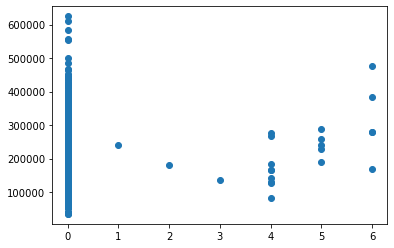

In [58]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['RoofMatl'])
RoofMatl_labels = le.transform(df['RoofMatl'])

fig,ax = plt.subplots()
ax.scatter(RoofMatl_labels, df['SalePrice'])

fig

Iz gornje slike je također vidljivo da nam materijal od kojeg je krov napravljen, ne govori puno o cijeni pa brišemo i taj atribut.

In [59]:
df.drop('RoofMatl', axis=1, inplace=True)

### Fireplaces

Još jedan zanimljiv atribut je `Fireplaces`, koliko kuća ima kamina

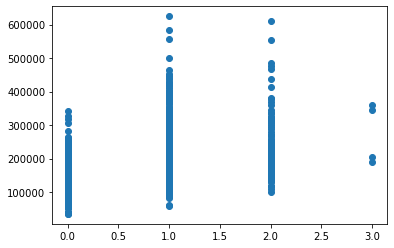

In [60]:
fig,ax = plt.subplots()

ax.scatter(df['Fireplaces'], df['SalePrice'])

fig

Vidimo da činjenica koliko kuća ima `Fireplaces` ne utječe previše na cijenu, pa možemo zamijeniti ovaj atribut s binarnim atributom `HasFireplace`

In [61]:
df['HasFireplace'] = 0
df.loc[df['Fireplaces'] > 0, 'HasFireplace'] = 1
df.drop('Fireplaces', axis=1, inplace=True)

## Pretvaranje kategorijskih atributa u numeričke one-hot encodingom

In [62]:
obj_df = df.select_dtypes(include=['object']).copy() #sve kategorijske atribute stavljamo u obj_df
df.drop('Id', axis=1, inplace=True) #mičemo i Id column jer nam neće kasnije biti potreban tokom učenja

In [63]:
obj_df.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [64]:
df.drop(obj_df.columns, axis=1, inplace=True) #ostaju nam samo numerički atributi u originalnom DataFrameu

Sada ćemo maknuti sve kategorijske atribute kojima fali više od 80% podataka

In [65]:
for column in obj_df.columns:
    if obj_df.isnull()[column].sum() > 0.8*obj_df.shape[0]:
        obj_df.drop(column,axis=1, inplace=True)
obj_df = obj_df.fillna({column:'nepoznatno' for column in obj_df.columns})
obj_df=pd.get_dummies(obj_df, columns=obj_df.columns, prefix=obj_df.columns)

Još ćemo kod numeričkih atributa sve `NaN` vrijednosti zamijeniti sa -100 kako nebi uklonili previše podataka

In [66]:
df = df.fillna(-100)
df = df.join(obj_df)

Sada smo spremni spremiti očišćene podatke u novi DataFrame i spremit ga u csv datoteku

In [67]:
df.to_csv('new_train.csv', index=False)

## Pretvorba test dataseta u pogodan oblik za predikciju

Sljedeća funkcija nam samo služi tome da podatke iz test.csv datoteke moežemo svesti u pogodan oblik kasnije za učenje. Ponavljamo simetričan postupak kao i gore pri eksploratornoj analizi

In [68]:
def data_prepare(path): 

    
    df = pd.read_csv(path)
    df.drop('GarageYrBlt', axis=1, inplace=True)
    df.drop(['PoolArea', 'PoolQC'],axis=1, inplace=True)
    df.drop('RoofMatl', axis=1, inplace=True)
    df.drop('GarageCars', axis=1, inplace=True)
    df.drop('Utilities', axis=1, inplace=True)
    
    df['HasFireplace'] = 0
    df.loc[df['Fireplaces'] > 0, 'HasFireplace'] = 1
    df.drop('Fireplaces', axis=1, inplace=True)

    obj_df = df.select_dtypes(include=['object']).copy()
    df.drop('Id', axis=1, inplace=True)

    df.drop(obj_df.columns, axis=1, inplace=True)


    obj_df = obj_df.fillna({column:'nepoznatno' for column in obj_df.columns})
    obj_df=pd.get_dummies(obj_df, columns=obj_df.columns, prefix=obj_df.columns)

    df = df.fillna(-100)
    df = df.join(obj_df)

    return df

In [69]:
df_test = data_prepare('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

Nadalje, kako možda neki stupci neće biti prisutni kada napravimo one-hot encoding nad test setom, moramo dodati stupce koji fale, a nalaze se u train setu.

In [70]:
for column in df.drop('SalePrice', axis=1).columns:
       if column not in df_test.columns:
            df_test[column]=0

In [71]:
df_test = df_test[df.drop('SalePrice', axis=1).columns]

In [72]:
df_test.to_csv('new_test.csv', index=False)

In [73]:
df = pd.read_csv('new_train.csv') 
df_test = pd.read_csv('new_test.csv').shape

# Odabir modela

U ovom dijelu ćemo se pozabaviti odabirom modela koje ćemo koristiti pri učenju. Koristi ćemo sljedeće modele:
* **XGBoostRegressor**
* **LightGBMRegressor**
* **SVR**
* **ElasticNet**

Svakom tom modelu ćemo optimizirati hiper-parametre pomoću `GridSearchCV` objekta implementiranog u biblioteci sklearn.

`GridSearchCV` je metoda odabira najboljeg skupa parametara koje sami algoritmu ponudimo. Pritom algoritam radi unakrsnu validaciju na skupu. U ovom radu smo se odlučili da će to biti 5-fold cross validation, dakle za parametar vrijedi `cv = 5`

Način odabira paremetra i cijela implementacija se nalazi u drugim bilježnicama. Može se naći na githubu u bilježnici `GridSearch.ipynb`

Slijede najbolji dobiveni parametri modela

## XGBoostRegressor

In [74]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(colsample_bytree=0.4, gamma=0, learning_rate=0.01,
                          max_depth=3, min_child_weight=0, n_estimators=10000,
                          reg_alpha=0.1, reg_lambda=0.1, subsample=0.6, seed=42, tree_method='gpu_hist')

## LightGBMRegressor

In [75]:
from lightgbm import LGBMRegressor

                    
model_lgb = LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9, 
                          feature_fraction=0.2, feature_fraction_seed=9, learning_rate=0.05,
                          max_bin = 60, min_data_in_leaf=6, min_sum_hessian_in_leaf=10, 
                          n_estimators=1000, num_leaves=4, subsample=0.6, objective='regression', tree_method='gpu_hist')

## SVR

In [76]:
from sklearn.svm import SVR


model_svr = SVR(C=0.9034693877551021, epsilon=0.01)

## ElasticNet

In [77]:
from sklearn.linear_model import ElasticNet


model_enet = ElasticNet(alpha=0.0001, l1_ratio=1.0)

# Ansambl dobivenih modela

Neka je $ \mathbb{X}=\{x_1,x_2,\ldots,x_N\}$ skup ulaznih varijabli. Označimo sa: 



* $f_1:\mathbb{X} \to \mathbb{R}^+_0$ regresorsku funkciju XGBoost modela 

* $f_2:\mathbb{X} \to \mathbb{R}^+_0$ regresorsku funkciju LightGBM modela 

* $f_3:\mathbb{X} \to \mathbb{R}^+_0$ regresorsku funkciju SVR modela

* $f_4:\mathbb{X} \to \mathbb{R}^+_0$ regresorsku funkciju ElasticNet modela

* $y:\mathbb{X} \to \mathbb{R}^+_0$ ciljnu funkciju koju aproksimiramo


Tražimo najbolju težinsku kombinaciju modela oblika: $\sum_{k=1}^4{\omega_kf_k}$, gdje za $\omega_1, \omega_2, \omega_3, \omega_4$ takvu da vrijedi $\omega_1 + \omega_2 + \omega_3 + \omega_4 = 1$

Sljedeći korak je da nađemo $\omega_1,\omega_2,\omega_3,\omega_4 \in [0,1]$ takav da minimiziramo sljedeći izraz:

$$ \sqrt{\frac{\displaystyle \sum_{n=0}^{N}{{\left (\left(\sum_{k=1}^4{\omega_kf_k(x_n)}\right) - y(x_n)\right)^2}}}{\displaystyle N}} $$

In [78]:
def rmse(y_pred, y_target):
    return np.sqrt(np.mean(np.square(y_pred.reshape(-1,) - y_target.reshape(-1,))))

## Dobivanje najboljih parametara

Gore opisani problem nije jednostavan. Trebalo bi se tražiti minimum funkcije 4 varijable s dodatnim uvjetima. Rješenje toga bi zahtjevalo Lagrangeove multiplikatore. Da bismo izbjegli naporan račun mi ćemo napraviti brute-force rješenje. Ideja je sljedeća:

1. Generirati 10 000 kombinacija $(w_1, w_2, w_3, w_4)$, gdje je svaki $w$ dobiven iz funkcije `np.random.uniform(1,10)`

2. Normirati dobivene $w$ na način:   
$$\displaystyle \frac{w_i}{\sum_{k=1}^4{w_k}}, \quad \forall i \in \{1,2,3,4 \} \quad \Rightarrow \quad \omega_1 + \omega_2 + \omega_3 + \omega_4 = 1 $$
   
3. Za svaku kombinaciju $(w_1, w_2, w_3, w_4)$ napraviti unakrsnu validaciju (CV=5) za novi model: $\quad \displaystyle \sum_{k=1}^4{\omega_kf_k(x_n)}$
4. Odabrati one $(w_1, w_2, w_3, w_4)$ koji daju najmanju grešku

Gornji postupak je implementiran u funkciji `all_models_parameter`

In [79]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def all_models_parameter(df, *models):
    
    x, y = df.drop('SalePrice', axis=1).values, df['SalePrice'].values
    
    w = np.random.uniform(1,10, (20000,len(models)))

    w/=w.sum(axis=1).reshape(20000,1)
    
    scores = np.zeros(20000)
    

    
    for repeat in range(10):
        
        
    
        x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

        scaler = MinMaxScaler()

        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)
        
        for model in models:
            model.fit(x_train, y_train)

        model_xgb.fit(x_train,y_train)
        model_lgb.fit(x_train,y_train)
        model_svr.fit(x_train,y_train)
        model_enet.fit(x_train,y_train)
        
        predictions = np.zeros((len(models),y_test.size))
        
        for k in range(len(models)):
            predictions[k,:] = models[k].predict(x_test)
        
        
        
        M = w@predictions
     
        
        scores+= np.array([rmse(M[k], y_test) for k in range(M.shape[0]) ])
        

        print(f'{repeat+1}/10 done. RootMeanSquaredError:{scores[scores.argmin()]/(repeat+1)}, w = ({w[scores.argmin()]})')

     
        
     
    scores/=10
    

   
    
    return scores[scores.argmin()], w[scores.argmin()] #vraća minimalni score i najbolje parametre za taj score

Slijedi klasa `ansambl` koja će nam olakšati pisanje koda

In [80]:
class ansambl:
    def __init__(self, models, w):
        self.models = models
        self.w = w
    def fit(self, x, y):
        for model in self.models:
            model.fit(x, y)
            
    def predict(self, x):
        prediction = self.w[0]*self.models[0].predict(x)
        
        for k in range(1, len(self.models)):
            prediction+=self.w[k]*self.models[k].predict(x)
            
        return prediction
    
    def score(self, x,y_target):
        y_pred = self.predict(x)
        return np.sqrt(np.mean(np.square(y_pred.reshape(-1,) - y_target.reshape(-1,))))

## Ansambl svih modela

In [81]:
x, y = df.drop('SalePrice', axis=1).values, df['SalePrice'].values

score_svi, w_svi = all_models_parameter(df, model_xgb, model_lgb, model_svr, model_enet)

ansambl_svi = ansambl([model_xgb, model_lgb, model_svr, model_enet], w_svi)

1/10 done. RootMeanSquaredError:0.09006031958408152, w = ([0.32282637 0.04802568 0.1568863  0.47226165])
2/10 done. RootMeanSquaredError:0.09757044460237088, w = ([0.41596592 0.04534073 0.13770828 0.40098507])
3/10 done. RootMeanSquaredError:0.10052924922571853, w = ([0.34303815 0.04534282 0.21467624 0.3969428 ])
4/10 done. RootMeanSquaredError:0.10518453906245723, w = ([0.41460009 0.04867789 0.27299437 0.26372766])
5/10 done. RootMeanSquaredError:0.1028287809211492, w = ([0.36634719 0.08023929 0.27402524 0.27938828])
6/10 done. RootMeanSquaredError:0.10379746357602626, w = ([0.31865275 0.12031658 0.27117506 0.28985561])
7/10 done. RootMeanSquaredError:0.10193148458927336, w = ([0.37093017 0.08876694 0.2919054  0.2483975 ])
8/10 done. RootMeanSquaredError:0.10325783596568591, w = ([0.34307905 0.13678681 0.27749617 0.24263797])
9/10 done. RootMeanSquaredError:0.10519706116467359, w = ([0.37629826 0.11334281 0.25962898 0.25072995])
10/10 done. RootMeanSquaredError:0.10549721005522987, w 

## Ansambl LightGBMRegressora i XGBRegressora

In [82]:
x, y = df.drop('SalePrice', axis=1).values, df['SalePrice'].values

score_dva, w_dva = all_models_parameter(df, model_xgb, model_lgb)

ansambl_dva = ansambl([model_xgb, model_lgb], w_dva)

1/10 done. RootMeanSquaredError:0.10178002667585895, w = ([0.57374215 0.42625785])
2/10 done. RootMeanSquaredError:0.10120339576970727, w = ([0.73628418 0.26371582])
3/10 done. RootMeanSquaredError:0.10783778966991941, w = ([0.67874185 0.32125815])
4/10 done. RootMeanSquaredError:0.10842172468542706, w = ([0.768255 0.231745])
5/10 done. RootMeanSquaredError:0.11184550359798169, w = ([0.67436624 0.32563376])
6/10 done. RootMeanSquaredError:0.11219178482855091, w = ([0.65458637 0.34541363])
7/10 done. RootMeanSquaredError:0.11308071341183887, w = ([0.67116406 0.32883594])
8/10 done. RootMeanSquaredError:0.11344277207836177, w = ([0.63194512 0.36805488])
9/10 done. RootMeanSquaredError:0.11238383523331419, w = ([0.66863174 0.33136826])
10/10 done. RootMeanSquaredError:0.11125129059114433, w = ([0.6611906 0.3388094])


# Validacija modela na test setu za Kaggle

Sada ćemo iskoristiti sve podatke pri učenju kako bismo mogli dobiti čim bolji model. koristimo sve rezultate ( parametre ) dosadašnje analize i radimo submission na Kaggleu

## Treniranje modela na cijelom skupu

In [83]:
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('new_train.csv')

x, y = df.drop('SalePrice', axis=1).values, df['SalePrice'].values

scaler = MinMaxScaler()

x = scaler.fit_transform(x)

y = np.log1p(y)

In [84]:
model_xgb.fit(x,y)
model_lgb.fit(x,y)
model_svr.fit(x,y)
model_enet.fit(x,y)

ElasticNet(alpha=0.0001, l1_ratio=1.0)

## Testiranje modela na podacima iz test.csv

In [85]:
Ids = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')['Id']
df_test = pd.read_csv('new_test.csv')

x = df_test.values

x = scaler.transform(x)

df_test['Id'] = Ids #vraćamo Id stupac

modeli = [model_xgb, model_lgb, model_svr, model_enet, ansambl_dva, ansambl_svi]
modeli_imena = ['XGBRegressor', 'LightGBMRegressor', 'SVR', 'ElasticNet', 'XGB + LGBM', 'Ansambl svih modela']

for k in range(0, 6):
    df_test['SalePrice']=np.expm1(modeli[k].predict(x))
    df_test[['Id', 'SalePrice']].to_csv(f'{modeli_imena[k]}.csv', index=False)
    



## Prikaz rezultata


| Model | RMSE - Kaggle dataset |
| :---: | :---: |
| **LightGBMRegressor** | 0.12435 |
| **XGBRegressor + LGBMRegressor** | 0.12558 |
| **Ansambl svih modela** | 0.12937 |
| **XGBRegressor** | 0.12947 |
| **SVR** | 0.13747 |
| **ElasticNet** | 0.16057 |




Iz navedenog vidimo da je najbolji model dobiven s **LGBMRegressorom** i ima grešku: 0.12435

In [96]:
scores_kaggle = np.array([0.16057, 0.13747, 0.12947, 0.12937, 0.12558, 0.12435 ])
modeli_imena = ['ElasticNet', 'SVR', 'XGBR', 'Ansambl svih', 'XGB + LGBM', 'LGBM']

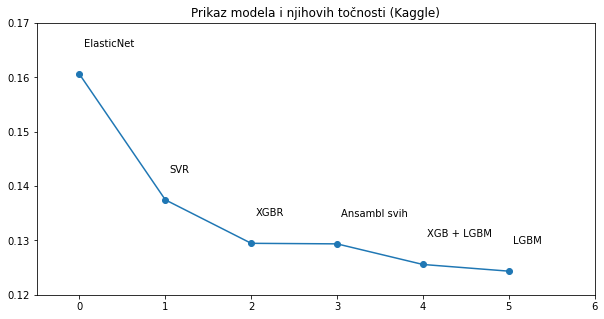

In [107]:
f, ax = plt.subplots(figsize=(10,5))



ax.plot(range(6), scores_kaggle, marker='o')
for k in range(6):
    ax.text(k+0.05, scores_kaggle[k]+0.001, modeli_imena[k])
    
ax.set(xlim=(-0.5,6), title='Prikaz modela i njihovih točnosti (Kaggle)', ylim=(0.12,0.17))

f

# Prikaz predikcija i reziduala na manjem skupu

In [87]:
x, y = df.drop('SalePrice', axis=1).values, df['SalePrice'].values

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)


model_xgb.fit(x_train,y_train)
model_lgb.fit(x_train,y_train)
model_svr.fit(x_train,y_train)
model_enet.fit(x_train,y_train)

ElasticNet(alpha=0.0001, l1_ratio=1.0)

In [88]:
f1, ax = plt.subplots(2,3, figsize=(20,10))


for k in range(3):
    ax[0,k].plot(range(y_test.size), modeli[k].predict(x_test), label=modeli_imena[k], color='red')
    ax[0,k].plot(range(y_test.size), y_test, label='prave vrijednosti', color='green')
    ax[0,k].legend(loc='upper left')
    if k == 0:
        ax[0,k].set(ylabel='Cijena kuće (log-skala)', title=f'Regresija: {modeli_imena[k]}')
    if k==1:
        ax[0,k].set(xlabel='Redni broj kuće', title=f'Regresija: {modeli_imena[k]}')
    if k==3:
        ax[0,k].set(title=f'Regresija: {modeli_imena[k]}')
        
    ax[1,k].scatter(range(y_test.size), modeli[k].predict(x_test) - y_test, color='gray')
    ax[1,k].set(title=f'Reziduali: {modeli_imena[k]}')
    
    ax[1,0].set(ylabel='Reziduali logaritmiranih vrijednosti')
    ax[1,1].set(xlabel='Redni broj kuće')
    
    
f2, ax = plt.subplots(2,3, figsize=(20,10))


for k in range(3):
    ax[0,k].plot(range(y_test.size), modeli[k+3].predict(x_test), label=modeli_imena[k+3], color='red')
    ax[0,k].plot(range(y_test.size), y_test, label='prave vrijednosti', color='green')
    ax[0,k].legend(loc='upper left')
    if k == 0:
        ax[0,k].set(ylabel='Cijena kuće (log-skala)', title=f'Regresija: {modeli_imena[k+3]}')
    if k==1:
        ax[0,k].set(xlabel='Redni broj kuće', title=f'Regresija: {modeli_imena[k+3]}')
    if k==3:
        ax[0,k].set(title=f'Regresija: {modeli_imena[k+3]}')
        
    ax[1,k].scatter(range(y_test.size), modeli[k+3].predict(x_test) - y_test, color='gray')
    ax[1,k].set(title=f'Reziduali: {modeli_imena[k+3]}')
    
    ax[1,0].set(ylabel='Reziduali logaritmiranih vrijednosti')
    ax[1,1].set(xlabel='Redni broj kuće')
    
    
    
f1.tight_layout()
f2.tight_layout()

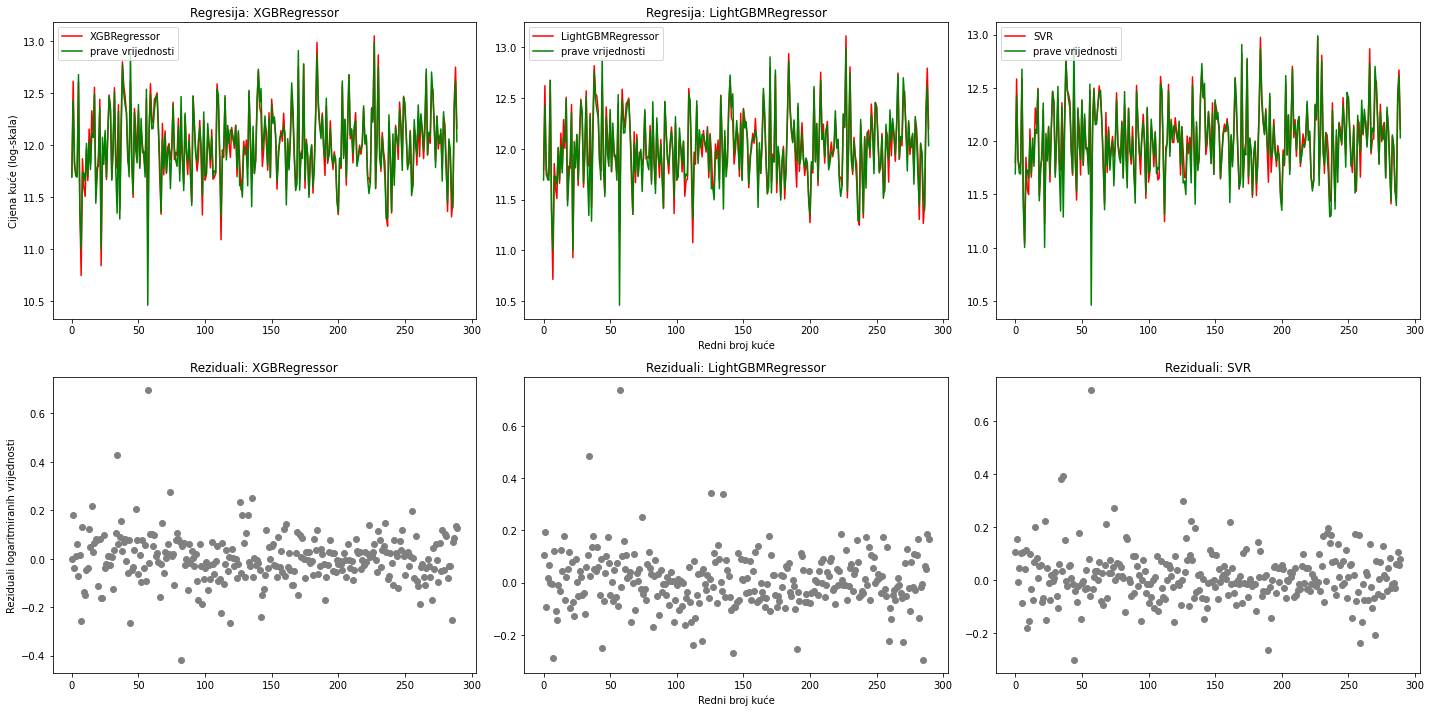

In [89]:
f1

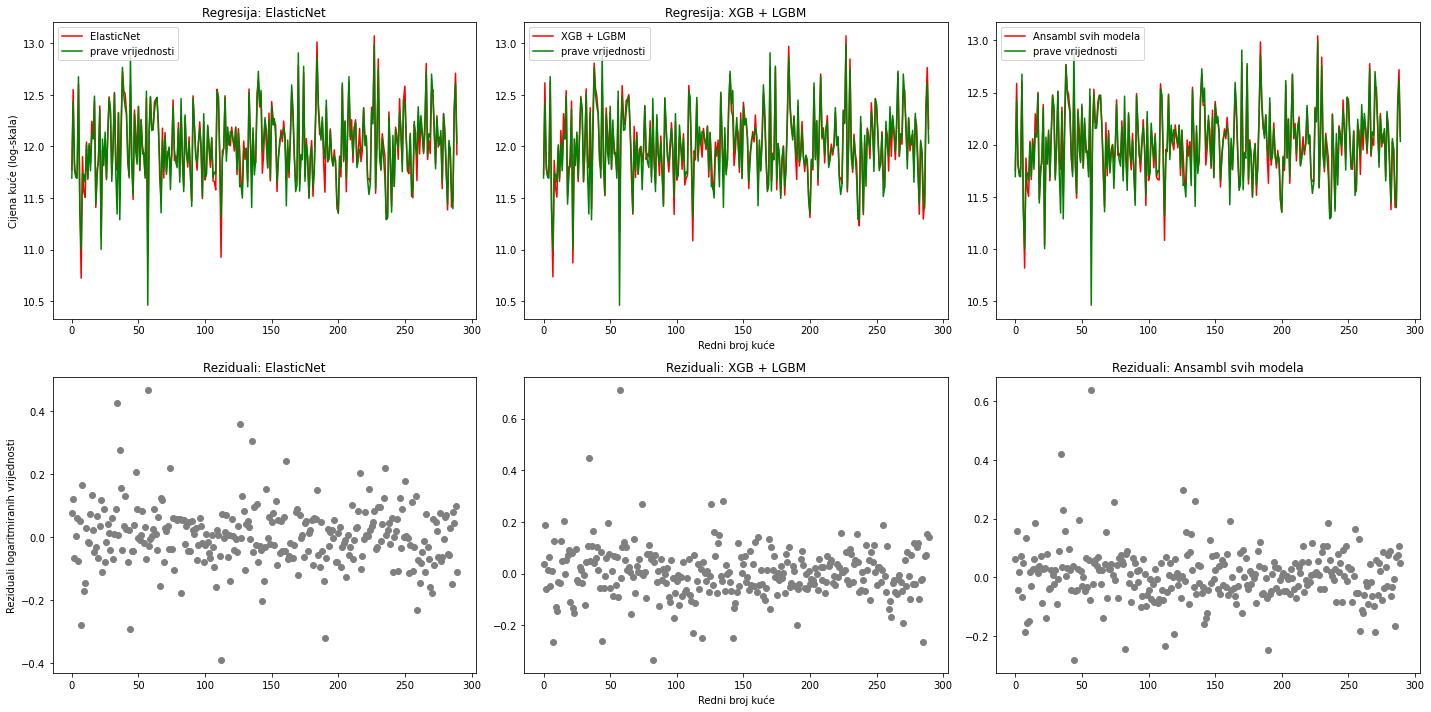

In [90]:
f2

# Završne napomene i nastavak istraživanja

Iako dobiveni model nije loš, postoje još stvari koje bi se morale uzeti u obzir kako bi se dobila manja greška:

1. **Podaci**
    * Micanje još outliera koje možda nismo uočili
    * Micanje featurea koji nisu toliko potrebni tokom učenja i ne pomažu pri predikciji ( filter/wrapper/embedded metode)
    * dodavanje novih featura na temelju već dostupnih
2. **Modeli** 
    * Testirati još više parametara za pojedini model
    * Probati ansamble i drugih modela 
    * Probati više modela

    